In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.patheffects as path_effects
import seaborn as sns
from unicodedata import normalize
import re
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob



In [13]:
# # pip install sqlalchemy pg8000 
# # !pip install sqlalchemy_utils
# !pip install wordcloud textblob

In [14]:
from sqlalchemy import create_engine, exists, MetaData, Table, BigInteger, Boolean,CHAR, select,  Column, DateTime, Integer, String, insert, update
from sqlalchemy.orm import sessionmaker, Session
from sqlalchemy_utils import database_exists, create_database
# from github_setup import postgresql as settings
from sqlalchemy.ext.declarative import declarative_base
from twitter_config import pins


url = f"postgresql+pg8000://{pins['user']}:{pins['password']}@{pins['host']}:{pins['port']}/{pins['db_name']}"

engine = create_engine(url)

Session = sessionmaker(bind=engine)

Base = declarative_base()

In [15]:
class Twitter(Base):
    """twitter table"""

    __tablename__ = "twitter"
    
    tweet_id = Column(String, primary_key=True)
    asa_id   = Column(String)
    user_id  = Column(String) 
    text     = Column(String)
    posted_at= Column(DateTime)   
    hashtags = Column(String)
    

class Interactions(Base):
    """Interactions table"""

    __tablename__ = "interactions"

    tweet_id = Column(String, primary_key=True)
    likes = Column(Integer)
    retweets = Column(Integer)
    protected = Column(Boolean)
    
class Historical_tweets(Base):
    """ Historical tweet table"""
    
    __tablename__ = "historical_tweets"
    
    id = Column(BigInteger, primary_key = True)
    date = Column(DateTime)
    user_id = Column(BigInteger)
    text = Column(String)
    retweets = Column(Integer)
    likes = Column(Integer)
    metionedusers = Column(String)
    asa_id = Column(String)
    protected = Column(Boolean)
    


Base.metadata.create_all(engine)


In [16]:
db = Session()

In [17]:
# id_twitter = db.query(Twitter).all()

# id_inter = db.query(Interactions).all()

id_hist = db.query(Historical_tweets).all()


In [18]:
id_hist[0].asa_id

'{230946361}'

### Transform class  tested !!!!!!!

In [19]:
class Transform():
    '''
    A class that reads data from database, perform all needed preprocessing 
    and return a DataFrame ready for analysis
    '''
    def __init__(self):
        self.data = None
    
    def get_twitter_df(self, ids, twitter_col:list):
        '''
        This function get the required data from the Twitter table in the database and places it in a Dataframe
        '''
        data = []
        for i in range(len(ids)):
            a,b,c,d,e,f = ids[i].tweet_id, ids[i].asa_id, ids[i].user_id, ids[i].text, ids[i].posted_at, ids[i].hashtags
            arr = np.array([a,b,c,d,e,f])
            data.append(arr)
        array = np.array(data)
        df = pd.DataFrame(array, columns = twitter_col)
        return df
    
    def get_inter_df(self, ids, inter_col:list):
        '''
        This function get the required data from the Interactions table in the database and places it in a Dataframe
        '''
        data = []
        for i in range(len(ids)):
            a,b,c,d = ids[i].tweet_id, ids[i].likes, ids[i].retweets, ids[i].protected
            arr = np.array([a,b,c,d])
            data.append(arr)
        array = np.array(data)
        df = pd.DataFrame(array, columns = inter_col)
        return df

    def get_hist_df(self, ids, twitter_col:list):
        '''
        This function get the required data from the Historical table in the database and places it in a Dataframe
        '''
        data = []
        for i in range(len(ids)):
            a,b,c,d,e,f,g,h,i = ids[i].id, ids[i].date, ids[i].user_id, ids[i].text, \
            ids[i].retweets, ids[i].likes, ids[i].metionedusers, ids[i].asa_id, ids[i].protected
            arr = np.array([a,b,c,d,e,f,g,h,i])
            data.append(arr)
        array = np.array(data)
        df = pd.DataFrame(array, columns = twitter_col)
        return df
    
    def merge_dfs(self, df1, df2):
        '''
        This function merges the twitter table and interaction table data
        '''
        df = pd.merge(df1, df2, how = 'inner', on = 'tweet_id')
        
        return df
    
    def clean_tweet(self, tweet):
        '''
        This function performs all necessary cleaning on the text data
        '''
        tweet = normalize('NFKD', tweet).encode('ascii', 'ignore').decode('utf-8')
        tweet = str(tweet)
        tweet = re.sub('(RT\s(@\w+))', '', tweet)
        tweet = re.sub('@\\w+', '', tweet)

        tweet = re.sub('((http|https):(\S+))', '', tweet)
        tweet = re.sub('[!#?:*%$]', ' ', tweet)
        tweet = re.sub('[^\s\w+]', '', tweet)
        tweet = re.sub('[\n]', '', tweet)
        tweet = tweet.lower().strip()
        return tweet
    
    def clean_id(self,df, column, historical = False):
        '''
        This functions cleans the ID column for '{}' or '[]'
        '''
        
        new = []
        for s in df[column]:
            s = s.lower()
            if not historical:
                
                n = s.replace('{', '')
                n = n.replace('}', '')
            else:
                n = s.replace('[', '')
                n = n.replace(']', '')
            new.append(n)
        df[column] = new
        return df
    
    def fix_type(self, df):
        '''
        This function converts the likes, retweets and protected columns to int64, int64 and bool respectively
        '''
#         data = self.data
        for i in df.columns:
            if i in ['likes', 'retweets']:
                df[i] = df[i].astype('int64')
            if i in ['protected']:
                df[i] = df[i].astype(bool)
            
        return df
    
    def choose_asa(self, df):
        '''
        This function extracts the needed ASA from the dataframe for analysis
        '''
#         data = self.data
        asa = input("Hey there! \nWhat ASA would you like to analyze? ").lower()
        data_asa = df[df['asa_id'].str.contains(asa, case = False)]
        data_asa.reset_index(inplace = True)
        return data_asa
    
    def alll(self, historical = False):
        '''
        This functions call all methods in the transform class in order and produce the final df for analytics
        '''
        col_t = ['tweet_id', 'asa_id', 'user_id', 'text', 'posted_at', 'hashtags']
        col_i = ['tweet_id', 'likes', 'retweets', 'protected']
        col_hist = ['id', 'date', 'user_id', 'text', 'retweets', 'likes', 'metionedusers', 'asa_id', 'protected']

        if historical:
            
            df_hist = self.get_hist_df(id_hist, col_hist)
            df_hist['clean_tweet'] = df_hist.text.apply(self.clean_tweet)
            df_hist = self.clean_id(df_hist, 'asa_id', historical = False)
            df_hist = self.fix_type(df_hist)
            df_final = self.choose_asa(df_hist)    
            
        else:
            
            df_twitter = self.get_twitter_df(id_twitter, col_t)
            df_inter = self.get_inter_df(id_inter, col_i)
            df = self.merge_dfs(df_twitter, df_inter)
            df['clean_tweet'] = df.text.apply(self.clean_tweet)
            df = self.clean_id(df, 'asa_id')
            df = self.fix_type(df)
            df_final = self.choose_asa(df)
        return df_final
        


In [ ]:

# df_t = Transform().get_hist_df(id_hist, col)
# df_t.head()

In [ ]:
# df_t.tail()

In [20]:
df_c = Transform().alll(historical=True)

Hey there! 
What ASA would you like to analyze? 297995609


In [21]:
df_algom = Transform().alll(historical=True)

Hey there! 
What ASA would you like to analyze? 230946361


In [22]:
df_yieldly = Transform().alll(historical=True)

Hey there! 
What ASA would you like to analyze? 226701642


In [23]:
df_shosha = Transform().alll(historical=True)

Hey there! 
What ASA would you like to analyze? 412056867


In [53]:
df_c.shape, df_algom.shape, df_yieldly.shape, df_shosha.shape

((528, 13), (4780, 13), (1426, 13), (638, 13))

## Likes class tested and works with transform

In [54]:
class Likes():
    
    def __init__(self, data, entity_col:str, datetime_col, compare_with:str = ''):
        
        self.data = data
        self.entity_col = entity_col
        self.datetime_col = data[datetime_col]
        self.compare_with = compare_with
    
    def day_of_week(self):
        '''
        This function extracts the day of the week from the datatime 
        column of the dataframe and adds it to the column
        '''
        data = self.data
        date = self.datetime_col
        day = date.dt.weekday
        data['day_of_week'] = day.to_list()
        encode_dict = {0: 'Sunday', 1:'Monday', 2:'Tuesday',
                        3: 'Wednesday', 4: 'Thursday',
                        5: 'Friday', 6: 'Saturday'}
        data['day_of_week'] = data['day_of_week'].replace(encode_dict)

        return data
    def hour_of_day(self):
        '''
        This function extracts the hour of the day from the datatime 
        column of the dataframe and adds it to the column
        '''
        data = self.data
        date = self.datetime_col
        time = date.dt.hour
        data['hour_of_day'] = time.to_list()
        return data
    
    def plot_line(self, c, xlab, ylab, title):
        '''
        Function to plot line graph
        
        c: Series or List
        xlab: str
        ylab: str
        title: str
        '''
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(12,4))
        plt.title(title)
        plt.xlabel(xlab+ ''+ '(UTC+1)')
        plt.ylabel(ylab)
        plt.plot(c, 'g-o',path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
#         plt.show()
        
        
    def plot_bar(self, x, y, xlab, ylab, title):
        '''
        Function to plot bar chart
        
        x: Series or List
        y: Series or List
        xlab: str
        ylab: str
        title: str
        '''
        
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(12,4))
        plt.title(title)
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.bar(x, y, color=['green'], path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
#         plt.show()
    def compare_bar(self, x, y1, y2):
        '''
        Function to plot multiple bar chart; compare two entities
        
        x: List
        y1: Pandas Series
        y2: Pandas Series
        '''
        data = self.data
        entity1 = self.entity_col
        entity2 = self.compare_with
        
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(12,4))
        
        x_axis = np.arange(len(x))
        
        plt.bar(x_axis-0.2, y1, 0.4, label = entity1, color=['green'],
               path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
        plt.bar(x_axis+0.2, y2, 0.4, label = entity2, color=['red'],
               path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
        
        plt.xticks(x_axis, x)
        plt.title(f"{entity1} Vs {entity2}")
        plt.xlabel("Weekdays")
        plt.ylabel(f"{entity1} and {entity2}")
        plt.legend()
        plt.show()
        
        
    def compare_line(self, c1, c2):
        '''
        Function to plot two line graph on the same grid; compare two entities
        
        c1: Pandas Series
        c2: Pandas Series
        '''
        
        data = self.data
        entity1 = self.entity_col
        entity2 = self.compare_with
        
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(12,4))
        
        plt.xlabel('Hour of the day (UTC+1)')
        plt.ylabel(f"{entity1} and {entity2}")
        plt.title(f"{entity1} Vs {entity2}")
        plt.plot(c1, 'g-o',label = entity1, path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
        plt.plot(c2, 'r-o', label = entity2, path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
        plt.legend()
        plt.show()
        
    def group(self, df, time_var:str, interest_var:str, custom = False):
        
        '''
        Function to group by time_var and get sum of interest_var per time_var:
        
        time_var: a categorical variable
        interest_var: numeric
        '''
        
        custom_index = ['Sunday', 'Monday', 'Tuesday',\
                        'Wednesday','Thursday', 'Friday', 'Saturday']
        h = df.groupby(time_var)[interest_var].sum()
        if custom:
            
            h = pd.Series(h, index = custom_index)
            return h
        else:
        
            return h
            
            
        
        
    def plot(self, weekday = False, timeofday = False):
        '''
        Function to initial different plot based on specified condition
        
        weekday: bool
        timeofday: bool
        '''
        data = self.data
        entity = self.entity_col
        entity2 = self.compare_with
        
        if weekday:
            df = self.day_of_week()
            
            if len(entity2) != 0:
                h1 = self.group(df, 'day_of_week', entity, custom = True)
                h2 = self.group(df, 'day_of_week', entity2, custom = True)
                self.compare_bar(h1.index, h1, h2)
            else:
                
                h = self.group(df, 'day_of_week', entity, custom = True)
                self.plot_bar(h.index, h,
                             xlab = 'day of the week',
                             ylab = f'{entity}',
                             title = f'{entity} per day of the week')
                plt.show()

        elif timeofday:
            df = self.hour_of_day()
            if len(entity2) != 0:
                c1 = self.group(df, 'hour_of_day', entity)
                c2 = self.group(df, 'hour_of_day', entity2)
                self.compare_line(c1,c2)
            else:
                
                c = self.group(df, 'hour_of_day', entity)

                self.plot_line(c,
                              xlab = 'Hour of the day',
                              ylab = f"{entity}",
                              title = f"Trend of {entity} per hour of day")
                plt.show()


        else:
            if len(entity2) != 0:
                d1 = data[entity]
                d2 = data[entity2]
                self.compare_line(d1,d2)
            else:
            
            
                self.plot_line(data[entity],
                              xlab = 'index',
                              ylab = f"{entity}",
                              title = f"Trend of {entity}")



In [55]:
class Text():
    '''
    THis class takes care of all text-based analytics
    
    wordcloud
    sentiment
    '''
    
    def __init__(self, df, column:str):
        self.df = df
        self.column = column
        self.text = df[column]
        
    def wordcloud(self):
        '''
        Function to plot wordcloud for text data
        '''
        text = self.text
        
        comment_words = ''
        stopwords = set(STOPWORDS)
 
        # iterate through the csv file
        for val in text:
     
            # typecaste each val to string
            val = str(val)
 
            # split the value
            tokens = val.split()
     
            # Converts each token into lowercase
            for i in range(len(tokens)):
                tokens[i] = tokens[i].lower()
     
            comment_words += " ".join(tokens)+" "
 
        wordcloud = WordCloud(width = 900, height = 300,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
        # plot the WordCloud image 
        plt.style.use('fivethirtyeight')
        plt.figure(figsize = (15, 10), facecolor = None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
 
        return plt.show()
        
    def sentiment(self):
        '''
        Function to get sentiment score for text data
        '''
        df = self.df
        column = self.df
        text = self.text
        senti = []
        score = [TextBlob(t).sentiment.polarity for t in text ]
        for s in score:
            if s > 0:
                senti.append(1)
            elif s == 0:
                senti.append(0)
            else:
                senti.append(-1)
        df['sentiment_score'] = senti
        return df
    def plot_sentiment(self):
        '''
        Function to plot sentiment category on a bar chart
        '''
        df = self.sentiment()
        
        code = {1: 'positive', -1: 'negative', 0:'neutral'}
        df['sentiment_score'].replace(code, inplace = True)
        s = df['sentiment_score'].value_counts()
        
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(12,4))
        plt.title('Sentiment Analysis')
        plt.xlabel('Category')
        plt.ylabel('Score')
        plt.bar(s.index, s, color=['green'])
        plt.show()
        

# Choice Coin

**Likes per hour of day** :From the graph, it can be seen that tweets made in the 10th hour of the day have the highest likes, followed by the 17th hour. On the contrary, 3th and 19th hour have low likes

**Likes per day of week** : Tweets made on Saturday, Tuesday and Sunday have high likes, while thursday have the minimum

**Trends of likes** : Maximum likes is >300 and there is a pattern in the trend.


**Retweets** : Retweets follow almost same pattern as Likes and this follow logical sense. Also, likes are generally higher than retweets per tweets

**Sentiment**: There are higher positive sentiments, a few negative and medium neutral

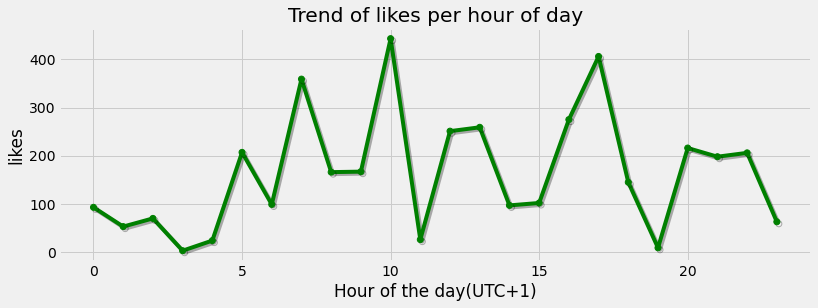

In [56]:
choice = Likes(df_c, 'likes', 'date')
choice.plot(timeofday=True)


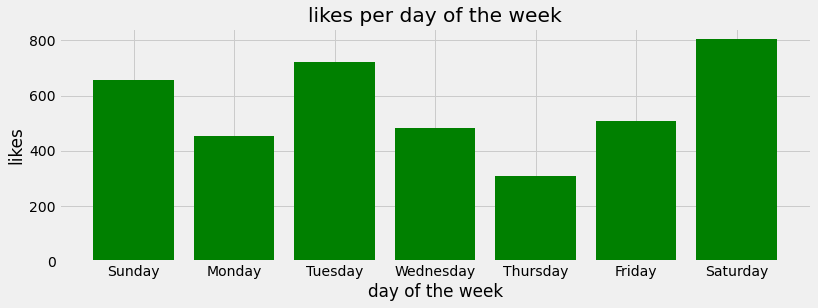

In [57]:
choice.plot(weekday = True)

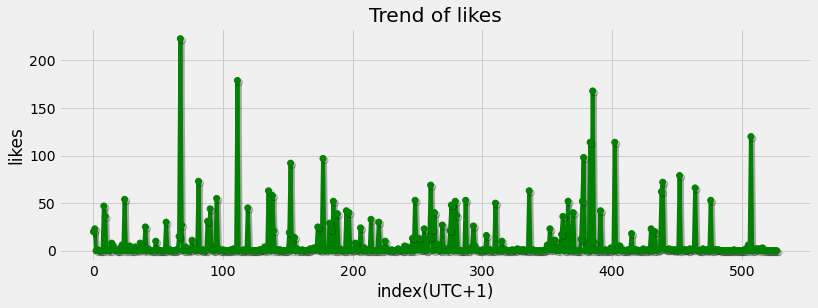

In [58]:
choice.plot()

In [59]:
class Retweets(Likes):
    pass
    

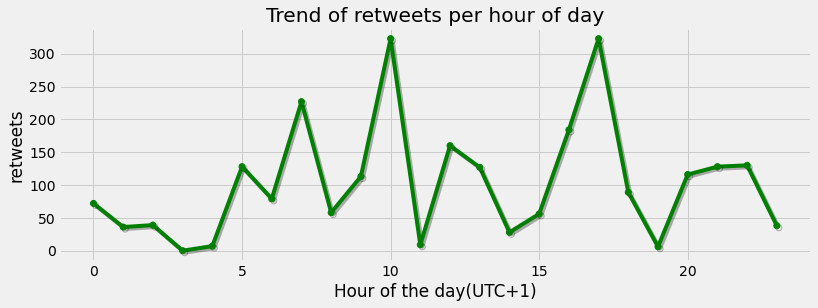

In [60]:
choice_ret = Retweets(df_c, 'retweets', 'date')
choice_ret.plot(timeofday=True)


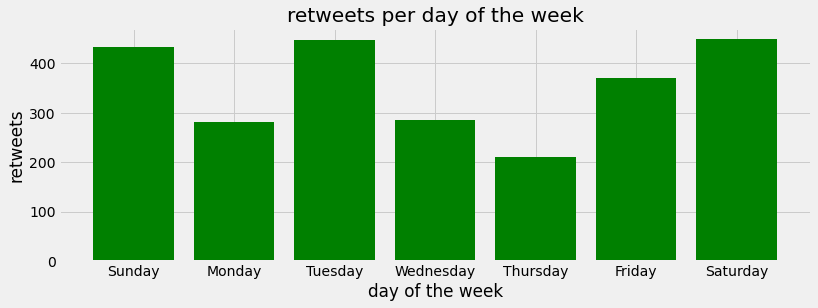

In [61]:
choice_ret.plot(weekday = True)

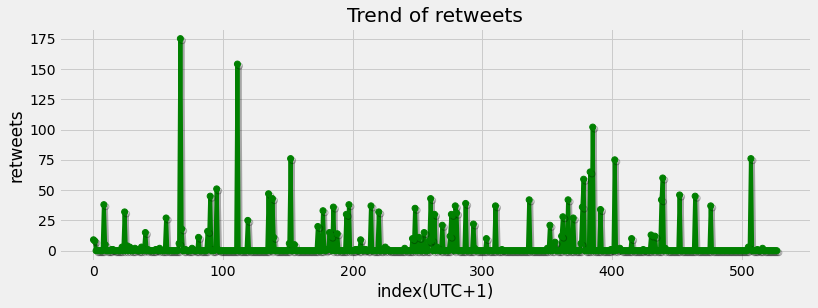

In [62]:
choice_ret.plot()

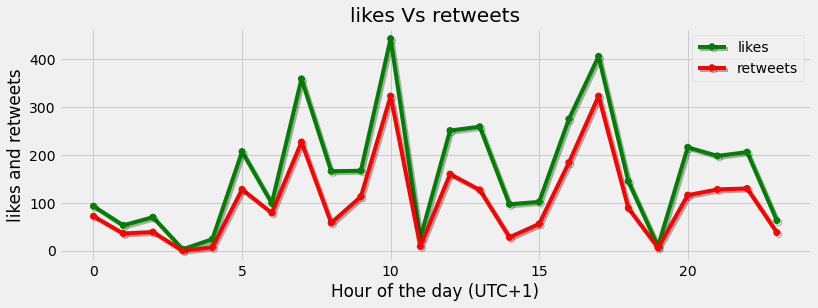

In [63]:
choice_comp = Likes(df_c, 'likes', 'date', compare_with= 'retweets')
choice_comp.plot(timeofday=True)


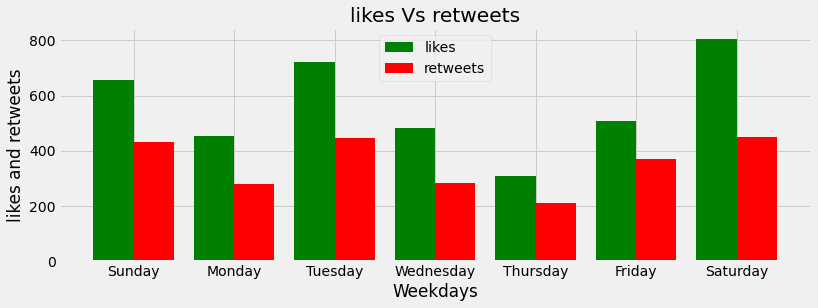

In [64]:
choice_comp.plot(weekday = True)

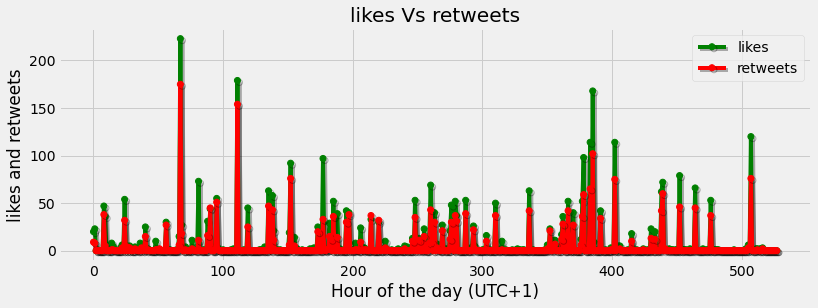

In [65]:
choice_comp.plot()

In [66]:
df_c.columns

Index(['index', 'id', 'date', 'user_id', 'text', 'retweets', 'likes',
       'metionedusers', 'asa_id', 'protected', 'clean_tweet', 'hour_of_day',
       'day_of_week'],
      dtype='object')

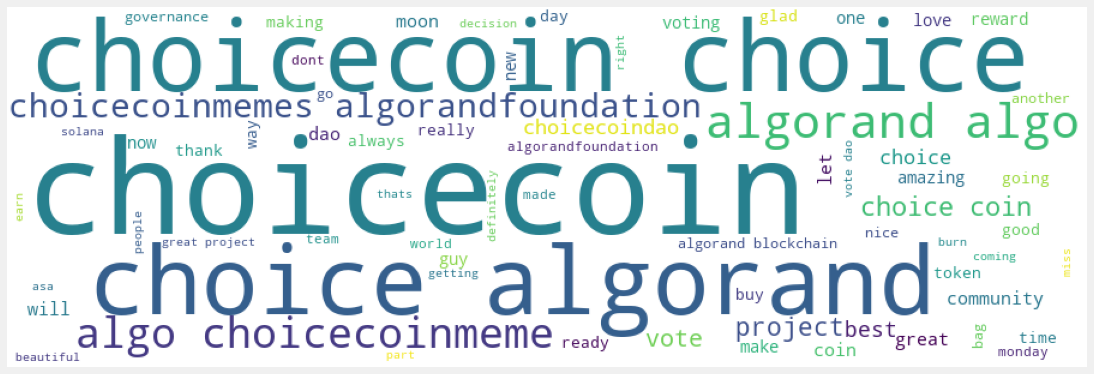

In [67]:
choice_t = Text(df_c, 'clean_tweet')
choice_t.wordcloud()

In [68]:
choice_t.sentiment().head()

,index,id,date,user_id,text,retweets,likes,metionedusers,asa_id,protected,clean_tweet,hour_of_day,day_of_week,sentiment_score
0,202,1481273313783693312,2022-01-12 14:34:13,1449480472002801664,"Make decisions, Get rewarded!\n\n""Having the p...",9,20,None,297995609,False,make decisions get rewarded having the privile...,14,Tuesday,1
1,221,1481245515509641219,2022-01-12 12:43:45,1449480472002801664,"The Testimonies Keep Pouring! \n $CHOICE\n""It ...",8,23,None,297995609,False,the testimonies keep pouring choiceit feels...,12,Tuesday,1
2,266,1519737936140541953,2022-04-28 17:58:53,3047701923,@ChoiceCoinDAO @ChoiceCoinAlgo @ChoiceCoinArmy...,0,0,"[User(username='ChoiceCoinDAO', id=14095698427...",297995609,False,with choicecoin wagmi is sure,17,Wednesday,1
3,313,1519650070760759296,2022-04-28 12:09:45,1454536431301500935,@ChoiceCoinDAO @patrickbennett @JohnMizzoni @i...,0,1,"[User(username='ChoiceCoinDAO', id=14095698427...","297995609, 226701642",False,our number one choice,12,Wednesday,0
4,351,1477370973036990469,2022-01-01 20:07:42,1351594602759925761,ChoiceCoin is the ever best among the good pr...,0,0,None,297995609,False,choicecoin is the ever best among the good pr...,20,Friday,1


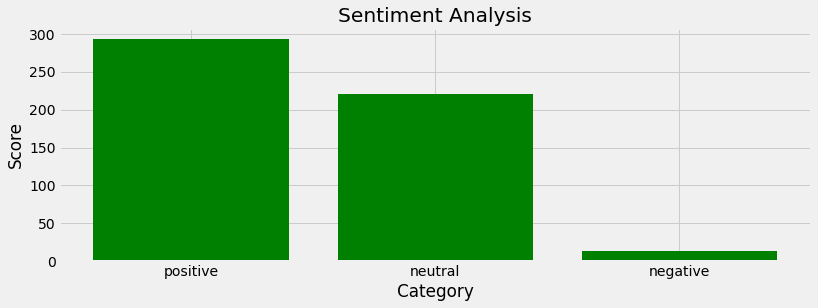

In [69]:
choice_t.plot_sentiment()

# Algomint

**Likes per hour of day** :From the graph, it can be seen that tweets made in the >22th hour of the day have the highest likes, followed by the 5th hour. On the contrary, around 7th hour have low likes

**Likes per day of week** : Tweets made on Tuesday, Wednesday and Sunday have high likes, while Friday have the minimum

**Trends of likes** : Maximum likes is >1000 and there is a pattern in the trend.


**Retweets** : Retweets follow almost same pattern as Likes and this follow logical sense. Also, likes are generally higher than retweets per tweets

**Sentiment**: There are higher neutral sentiments, a few positive and medium negative

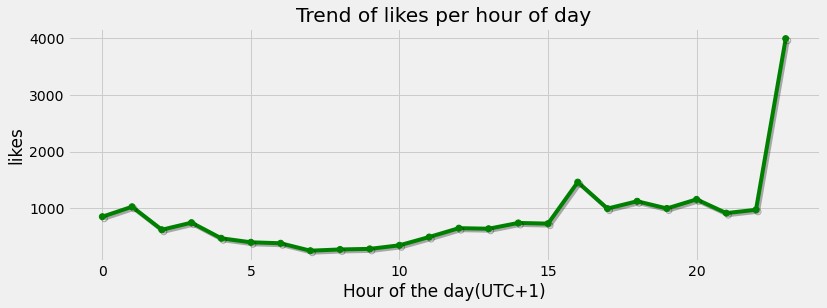

In [70]:
mint = Likes(df_algom, 'likes', 'date')
mint.plot(timeofday=True)


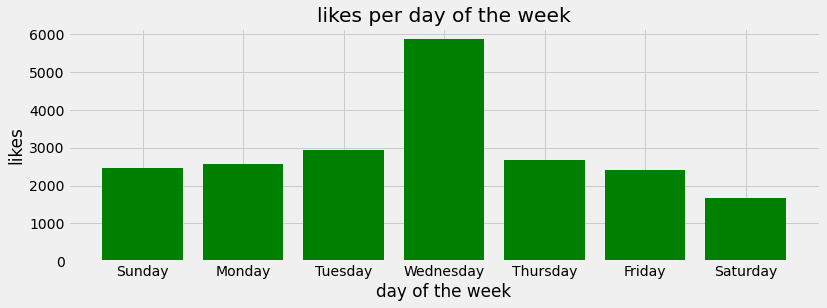

In [71]:
mint.plot(weekday = True)


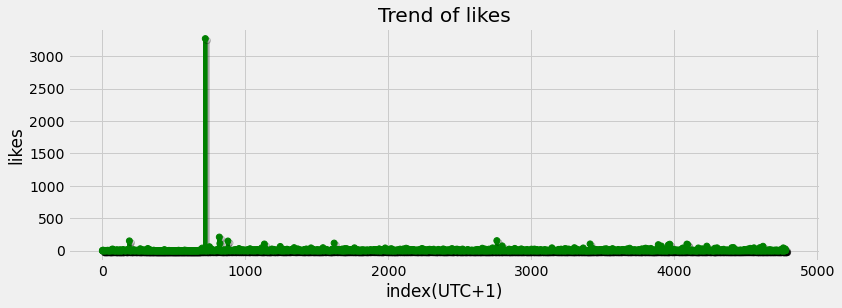

In [72]:
mint.plot()

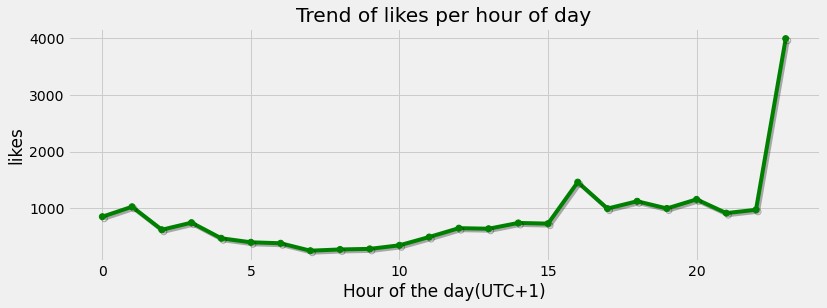

In [73]:
mint_r = Retweets(df_algom, 'likes', 'date')
mint_r.plot(timeofday=True)


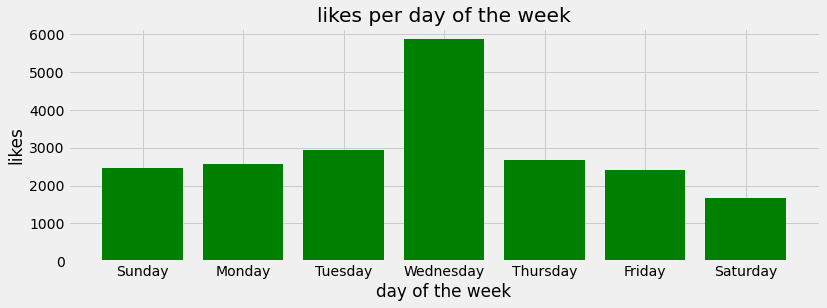

In [74]:
mint_r.plot(weekday = True)


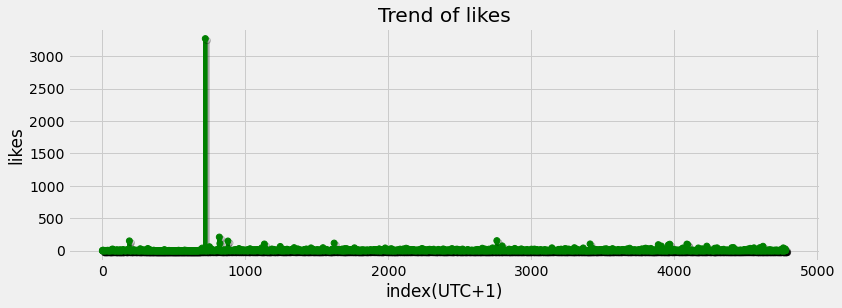

In [75]:
mint_r.plot()

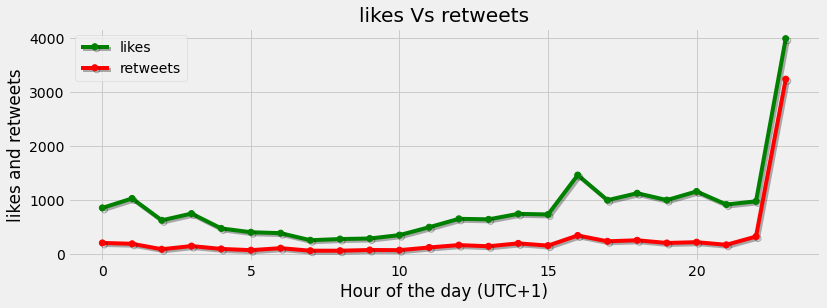

In [76]:
mint_compare = Likes(df_algom, 'likes', 'date', compare_with = 'retweets')
mint_compare.plot(timeofday=True)


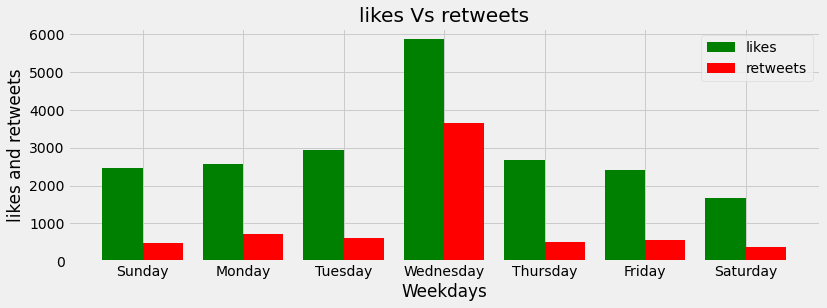

In [77]:
mint_compare.plot(weekday = True)


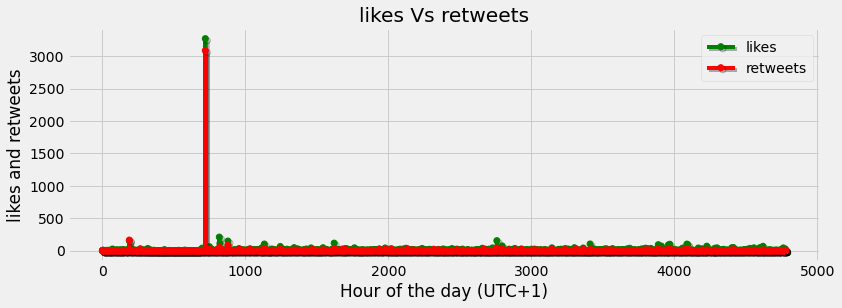

In [78]:
mint_compare.plot()

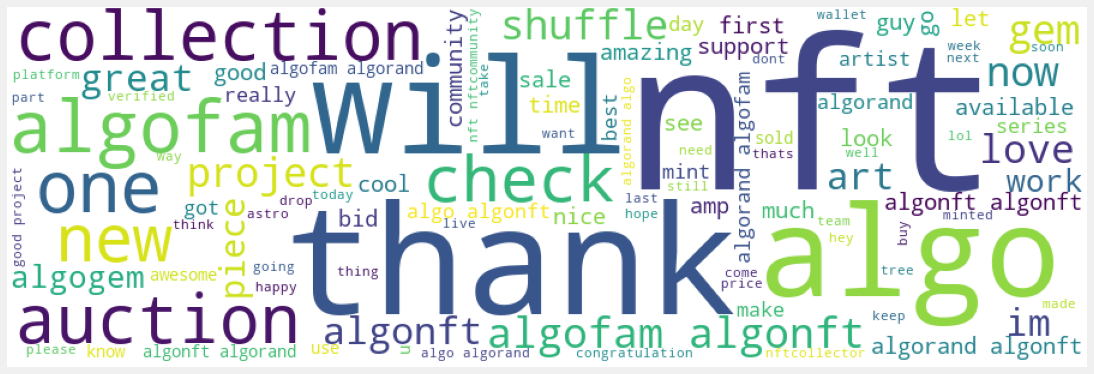

In [79]:
mint_t = Text(df_algom, 'clean_tweet')
mint_t.wordcloud()

In [80]:
mint_t.sentiment().head()

,index,id,date,user_id,text,retweets,likes,metionedusers,asa_id,protected,clean_tweet,hour_of_day,day_of_week,sentiment_score
0,0,1520189574416375808,2022-04-29 23:53:32,1485617376662069251,@TheeCryptoBeefy @MushiesNFT @AlgogemsNFT Nice...,0,0,"[User(username='TheeCryptoBeefy', id=897815996...",230946361,False,nice love the fly agaric cap,23,Thursday,1
1,1,1520186718963523585,2022-04-29 23:42:12,1408320836814077952,@CryptoTreesASA @algo_stake @AlgogemsNFT Nice ...,0,0,"[User(username='CryptoTreesASA', id=1464341140...",230946361,False,nice project,23,Thursday,1
2,4,1520173179464998915,2022-04-29 22:48:24,3340667055,@Algorand @lofty_ai @NBCNews @AlgogemsNFT @Gem...,0,0,"[User(username='Algorand', id=9279098320022773...",230946361,False,algogems algo projesi,22,Thursday,0
3,16,1520152723185881090,2022-04-29 21:27:06,1054119716804050945,@CryptoTreesASA @algo_stake @AlgogemsNFT Amazi...,0,0,"[User(username='CryptoTreesASA', id=1464341140...",230946361,False,amazing project,21,Thursday,1
4,19,1520137186909487104,2022-04-29 20:25:22,1467432518118952962,@CryptoTreesASA @algo_stake @AlgogemsNFT Wonde...,0,0,"[User(username='CryptoTreesASA', id=1464341140...",230946361,False,wonderful project,20,Thursday,1


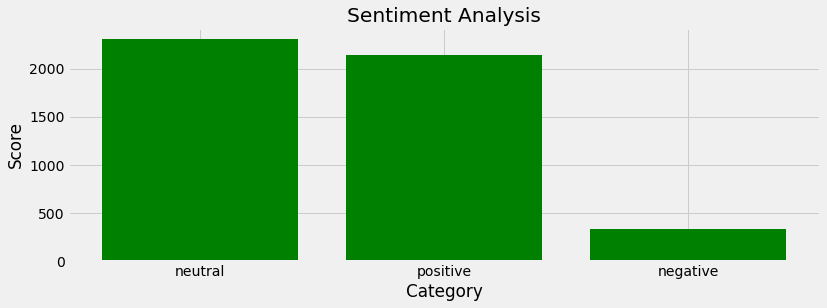

In [81]:
mint_t.plot_sentiment()

# Yieldly

**Likes per hour of day** :From the graph, it can be seen that tweets made in the 14th hour of the day have the highest likes, followed by the 16th hour. On the contrary, around 8th hour have low likes

**Likes per day of week** : Tweets made on Monday have high likes, while thursday  and Saturday have the minimum

**Trends of likes** : Maximum likes is >250 and there is a pattern in the trend.


**Retweets** : Retweets for yieldly are significantly lower than likes. The yieldly community most likely prefer to just like tweets

**Sentiment**: There are higher positive sentiments, a few negative (significant amount and this could be due to the explosion on their pool) and medium neutral

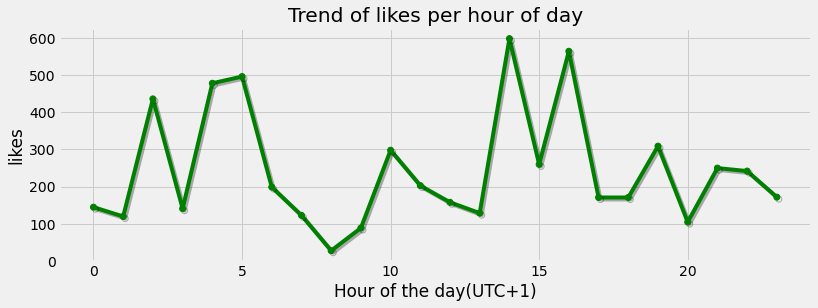

In [82]:
yieldly = Likes(df_yieldly, 'likes', 'date')
yieldly.plot(timeofday=True)


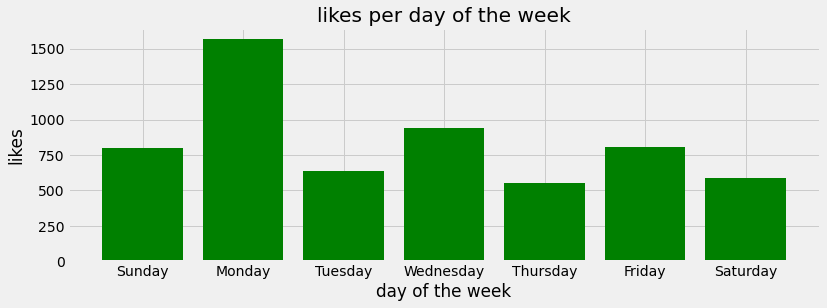

In [83]:
yieldly.plot(weekday = True)


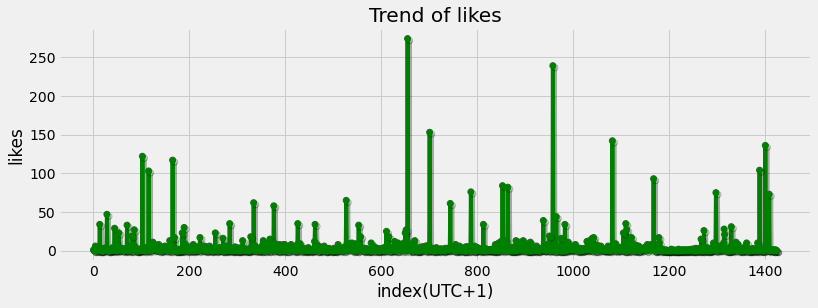

In [84]:
yieldly.plot()

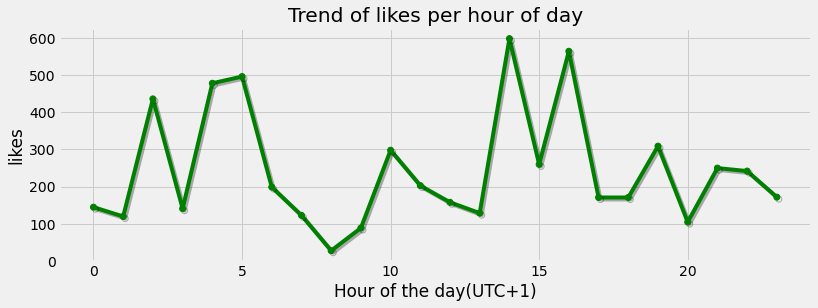

In [85]:
yieldly_r = Retweets(df_yieldly, 'likes', 'date')
yieldly_r.plot(timeofday=True)


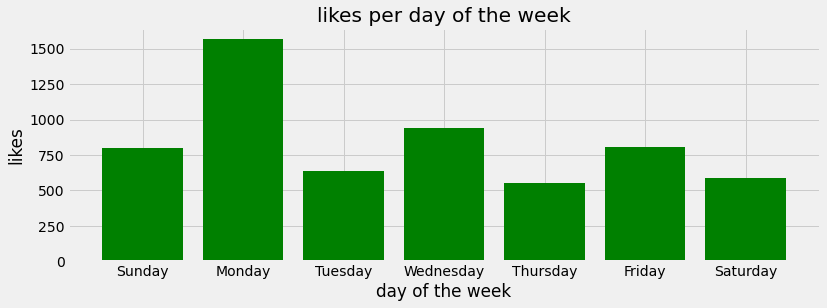

In [86]:
yieldly_r.plot(weekday = True)


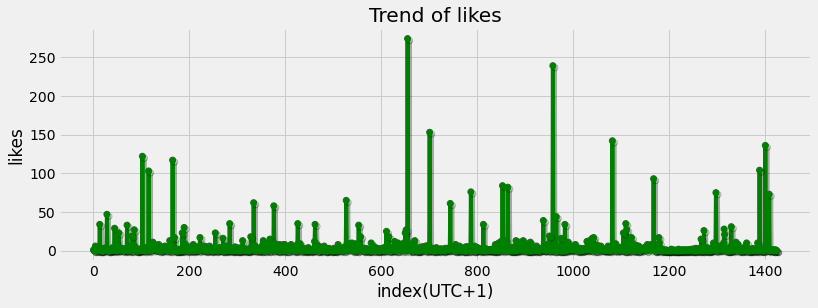

In [87]:
yieldly_r.plot()

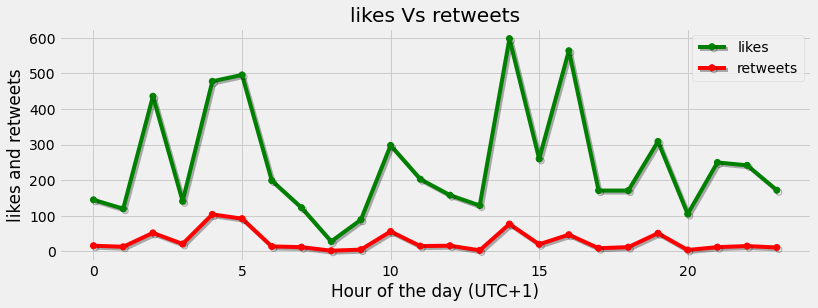

In [88]:
yieldly_comp = Likes(df_yieldly, 'likes', 'date', compare_with = 'retweets')
yieldly_comp.plot(timeofday=True)


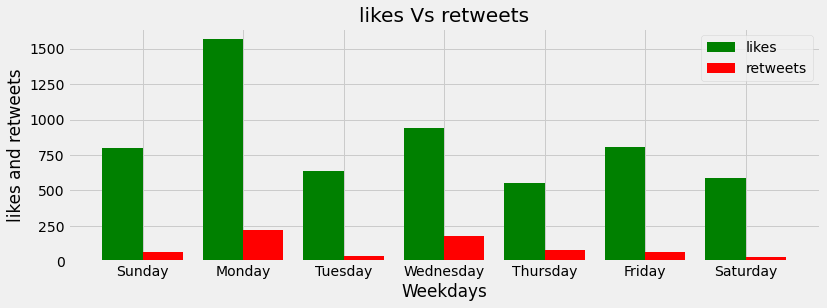

In [89]:
yieldly_comp.plot(weekday = True)


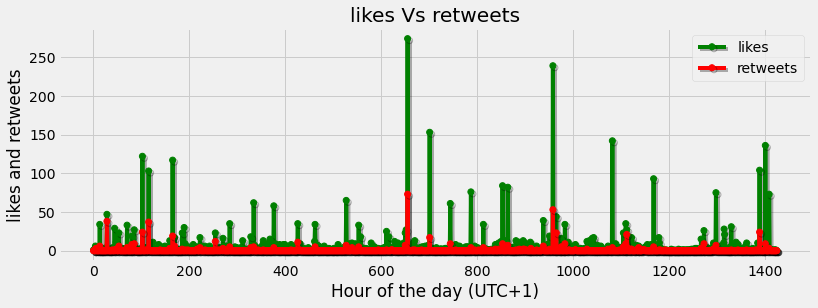

In [90]:
yieldly_comp.plot()

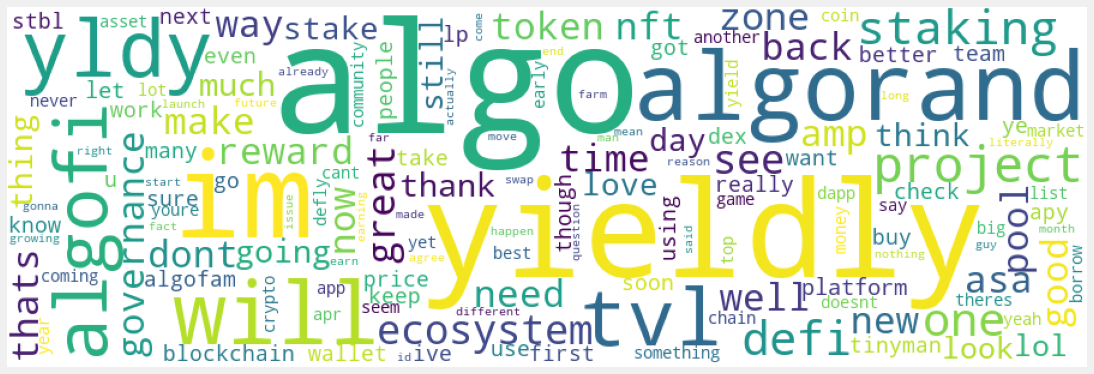

In [91]:
yieldly_t = Text(df_yieldly, 'clean_tweet')
yieldly_t.wordcloud()

In [92]:
yieldly_t.sentiment().head()

,index,id,date,user_id,text,retweets,likes,metionedusers,asa_id,protected,clean_tweet,hour_of_day,day_of_week,sentiment_score
0,24,1520124582996459520,2022-04-29 19:35:17,2275560857,@crypttortue @PeraAlgoWallet @myalgo_ @algofio...,0,1,"[User(username='crypttortue', id=1400143067013...","230946361, 226701642, 432023101",False,,19,Thursday,0
1,38,1520091920462192643,2022-04-29 17:25:30,1480359332575334401,Imagina quando a galera descobrir:\n@algofiorg...,0,0,"[User(username='algofiorg', id=139625526259653...","226701642, 432023101",False,imagina quando a galera descobrir defi...,17,Thursday,0
2,142,1519911678179426305,2022-04-29 05:29:17,1358230977621839872,@AirdropsMine good performance\n@algofiorg \n@...,0,0,"[User(username='AirdropsMine', id=148148718046...","226701642, 432023101",False,good performance,5,Thursday,1
3,313,1519650070760759296,2022-04-28 12:09:45,1454536431301500935,@ChoiceCoinDAO @patrickbennett @JohnMizzoni @i...,0,1,"[User(username='ChoiceCoinDAO', id=14095698427...","297995609, 226701642",False,our number one choice,12,Wednesday,0
4,519,1518980919574605824,2022-04-26 15:50:47,1328761300630048778,STAKING WITH #ALGORAND! HOW TO USE #ALGORAND #...,1,6,"[User(username='PeraAlgoWallet', id=1475829828...","226701642, 432023101",False,staking with algorand how to use algorand ...,15,Monday,0


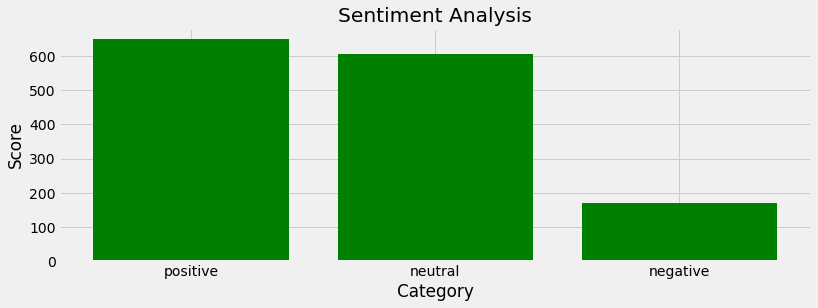

In [93]:
yieldly_t.plot_sentiment()

# Shosha

**Likes per hour of day** :From the graph, it can be seen that tweets made in the 12th hour of the day have the highest likes. On the contrary, 0th and 5th hour have low likes

**Likes per day of week** : Tweets made on Saturday and Sunday have high likes, while thursday have the minimum

**Trends of likes** : Maximum likes is >700 and there is a pattern in the trend.


**Retweets** : Retweets follow almost same pattern as Likes and this follow logical sense. Also, likes are generally higher than retweets per tweets

**Sentiment**: There are higher nuetral sentiments, a few positive and  negatives

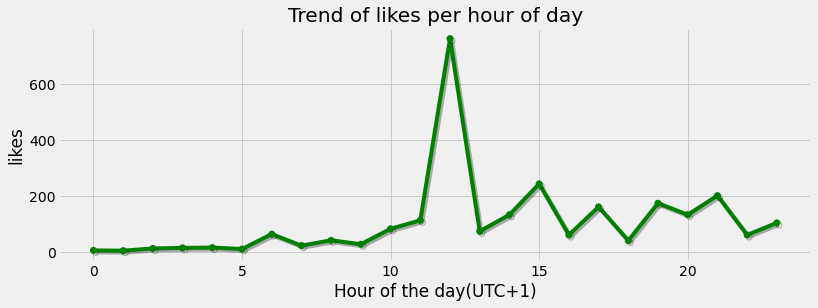

In [94]:
shosha = Likes(df_shosha, 'likes', 'date')
shosha.plot(timeofday=True)


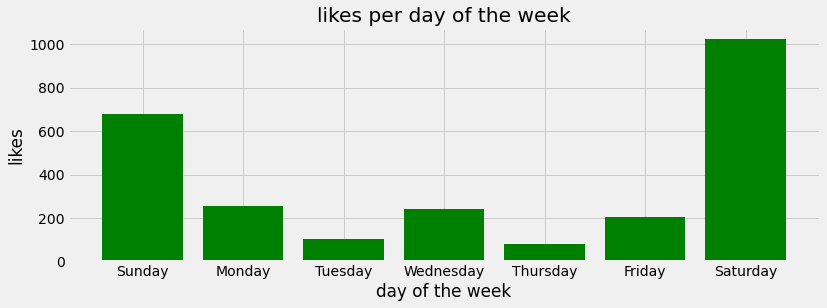

In [95]:
shosha.plot(weekday = True)


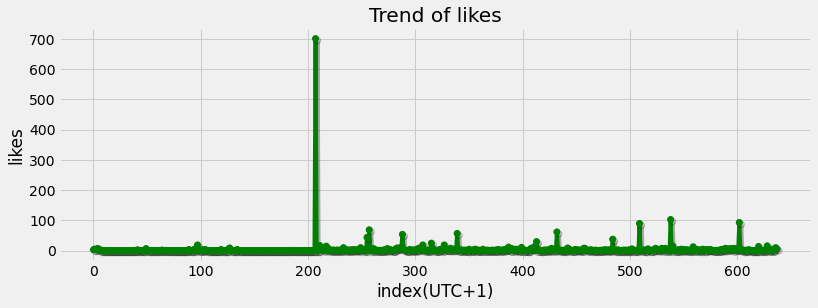

In [96]:
shosha.plot()

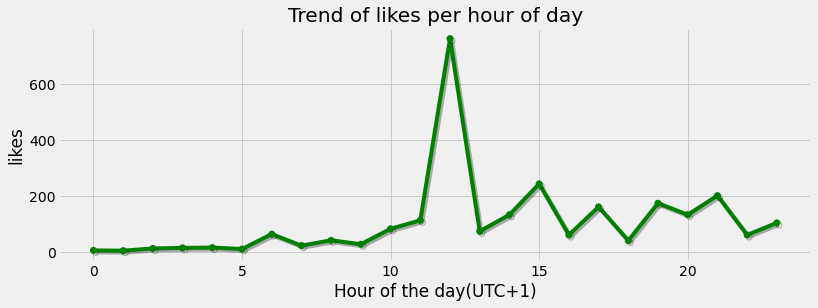

In [97]:
shosha_r = Retweets(df_shosha, 'likes', 'date')
shosha_r.plot(timeofday=True)


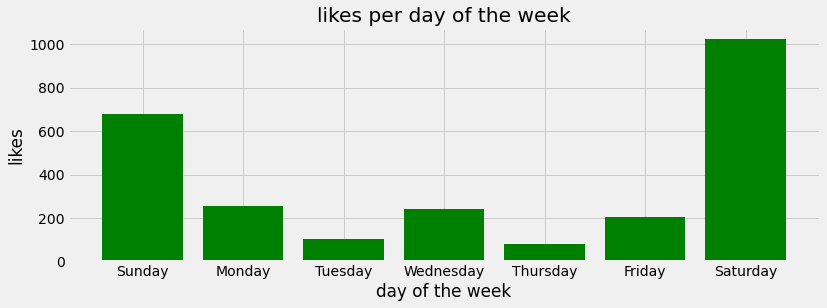

In [98]:
shosha_r.plot(weekday = True)


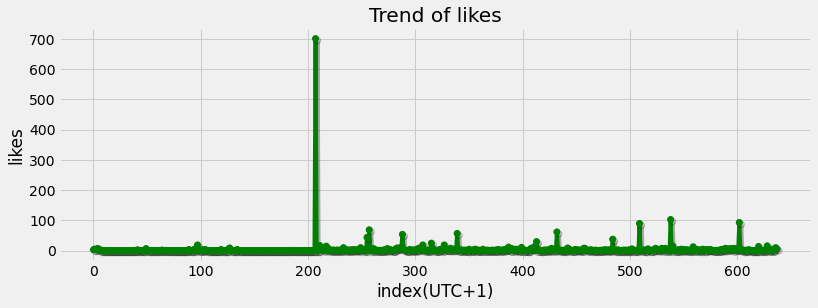

In [99]:
shosha_r.plot()

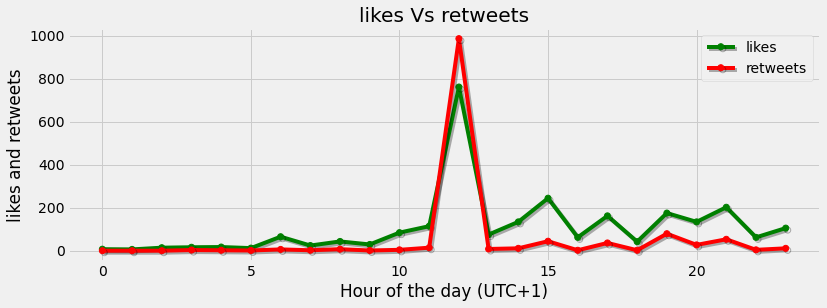

In [100]:
shosha_compare = Likes(df_shosha, 'likes', 'date', compare_with = 'retweets')
shosha_compare.plot(timeofday=True)


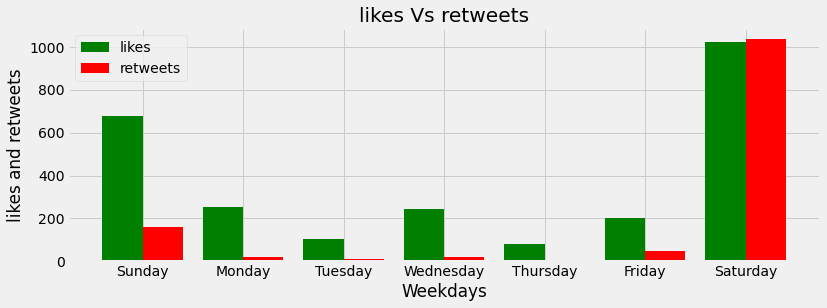

In [101]:
shosha_compare.plot(weekday = True)


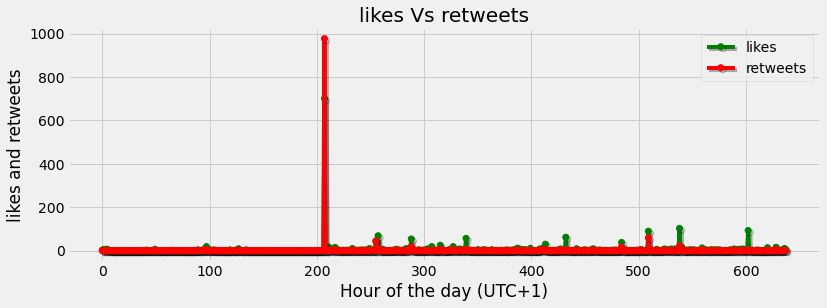

In [102]:
shosha_compare.plot()

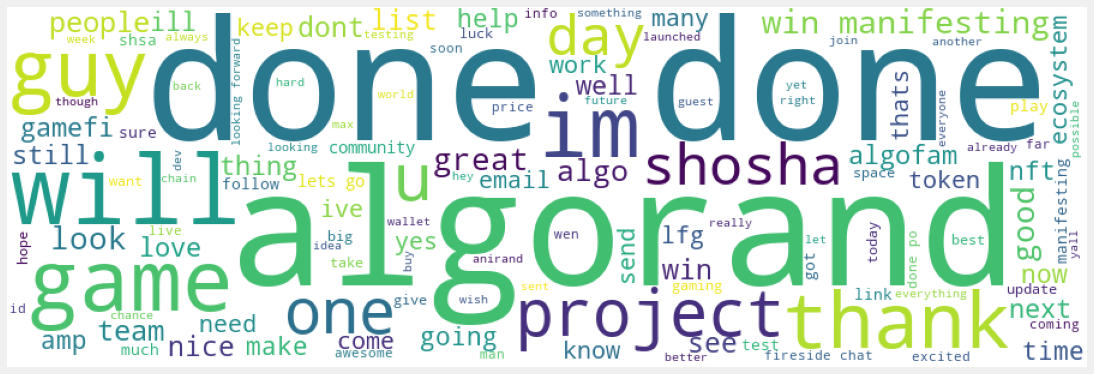

In [103]:
shosha_t = Text(df_shosha, 'clean_tweet')
shosha_t.wordcloud()

In [104]:
shosha_t.sentiment().head()

,index,id,date,user_id,text,retweets,likes,metionedusers,asa_id,protected,clean_tweet,hour_of_day,day_of_week,sentiment_score
0,177,1519870214980182018,2022-04-29 02:44:31,1452845055778115585,@angry_penguins1 @gtaggallery @Extremebulls @S...,0,3,"[User(username='angry_penguins1', id=146751200...",412056867,False,,2,Thursday,0
1,179,1519867693742305280,2022-04-29 02:34:30,1467512006286581761,@gtaggallery @Algorand @AlgoGods @NRPG_officia...,0,5,"[User(username='gtaggallery', id=1512693964968...",412056867,False,,2,Thursday,0
2,180,1519867015770820608,2022-04-29 02:31:48,1467512006286581761,@gtaggallery @Extremebulls @ShoshaCrypto @digi...,0,4,"[User(username='gtaggallery', id=1512693964968...",412056867,False,,2,Thursday,0
3,209,1519828001612959746,2022-04-28 23:56:47,1492590050550632448,@gtaggallery @Algorand @AlgoGods @NRPG_officia...,0,6,"[User(username='gtaggallery', id=1512693964968...",412056867,False,lfg,23,Wednesday,0
4,212,1519826906379702272,2022-04-28 23:52:26,1464362881659637762,@gtaggallery @Algorand @AlgoGods @NRPG_officia...,0,7,"[User(username='gtaggallery', id=1512693964968...",412056867,False,,23,Wednesday,0


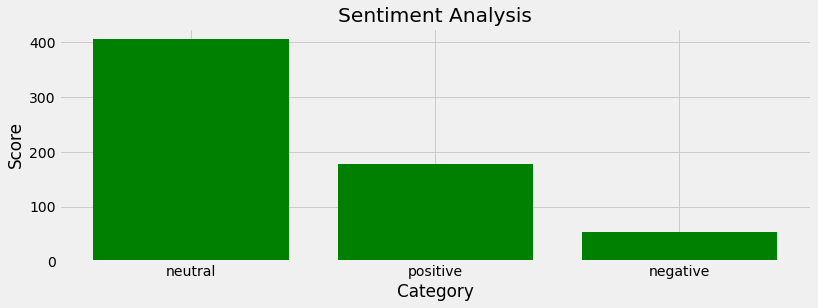

In [105]:
shosha_t.plot_sentiment()